In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Major_Project/Data/training.csv', nrows=16000)
data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
data['label'] = data['label'].map(labels_dict )

In [5]:
# checking for shape
data.shape

(16000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [7]:
# checking for missing values
data.isna().sum()

text     0
label    0
dtype: int64

In [8]:
data.label.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

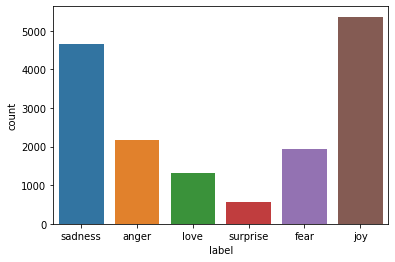

In [9]:
sns.countplot(x='label', data=data)

## Data Preprocessing

In [22]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [23]:
# Remove punctuation
data['text'] = data['text'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [24]:
# Remove stop words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [26]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Do lemmatization
from nltk.stem import WordNetLemmatizer
from textblob import Word
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['text'].head()

0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
Name: text, dtype: object

In [28]:
#separating the data and label
X = data[['text']]
y = data['label']

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# splitting into training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

In [31]:
#validate the shape of train and test dataset
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(11200, 1)
(11200,)
(4800, 1)
(4800,)


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['text'])
xtrain_tfidf = tfidf_vect.transform(X_train['text'])
xtest_tfidf = tfidf_vect.transform(X_test['text'])

# Model Building

## 1. Passive Aggressive Classifier

In [38]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
pclf = PassiveAggressiveClassifier()
pclf.fit(xtrain_tfidf, y_train)
predictions = pclf.predict(xtest_tfidf)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

       anger       0.85      0.82      0.84       648
        fear       0.81      0.82      0.81       581
         joy       0.87      0.89      0.88      1608
        love       0.74      0.72      0.73       391
     sadness       0.89      0.89      0.89      1400
    surprise       0.76      0.74      0.75       172

    accuracy                           0.85      4800
   macro avg       0.82      0.81      0.82      4800
weighted avg       0.85      0.85      0.85      4800



In [35]:
print(metrics.confusion_matrix(y_test,predictions)) 

[[ 529   23   29    6   60    1]
 [  26  475   26    7   28   19]
 [  22   21 1427   83   47    8]
 [   5    5   78  291   12    0]
 [  35   36   59    9 1252    9]
 [   3   28    7    4    9  121]]


In [36]:
def classify(emo):
    input_data = [emo]
    vectorized_input_data = tfidf_vect.transform(input_data)
    prediction = pclf.predict(vectorized_input_data)
    print(prediction)

In [37]:
classify("""i am playing cricket""")

['joy']


In [48]:
classify("""grabbing a minute to post i feel greedy wrong""")

['anger']


Entering a customised text

In [49]:
classify("""I feel elated""")

['fear']


In [50]:
classify("""I am scared of snakes""")

['fear']


## 2. MLP Classifier

In [39]:
from sklearn.neural_network import MLPClassifier
mlpclf = MLPClassifier(hidden_layer_sizes=(256,64,16),
                       activation = 'relu', 
                       solver = 'adam')
mlpclf.fit(xtrain_tfidf, y_train)
predictions = mlpclf.predict(xtest_tfidf)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

       anger       0.82      0.83      0.83       648
        fear       0.71      0.85      0.77       581
         joy       0.88      0.84      0.86      1608
        love       0.68      0.73      0.71       391
     sadness       0.89      0.85      0.87      1400
    surprise       0.67      0.60      0.63       172

    accuracy                           0.83      4800
   macro avg       0.77      0.78      0.78      4800
weighted avg       0.83      0.83      0.83      4800



In [40]:
print(metrics.confusion_matrix(y_test,predictions)) 

[[ 539   39   24    5   40    1]
 [  22  491   17    4   30   17]
 [  38   28 1351  113   53   25]
 [   9   11   71  286   14    0]
 [  43   76   69   12 1192    8]
 [   5   48    9    0    7  103]]


In [41]:
def classify(emo):
    input_data = [emo]
    vectorized_input_data = tfidf_vect.transform(input_data)
    prediction = mlpclf.predict(vectorized_input_data)
    print(prediction)

In [42]:
classify("""i didnt feel humiliated""")

['sadness']


In [43]:
classify("""I feel delighted""")

['joy']


In [44]:
classify("""I am shocked""")

['surprise']


In [45]:
classify("""Our teacher is pissed at us""")

['anger']


In [51]:
classify("""Today is gloomy""")

['sadness']
